In [1]:
import pandas as pd

In [2]:
df = pd.read_excel("./WindPowerForecastingData.xlsx")

print(df.head())


       TIMESTAMP  TARGETVAR       U10       V10      U100      V100
0  20120101 1:00   0.000000  2.124600 -2.681966  2.864280 -3.666076
1  20120101 2:00   0.054879  2.521695 -1.796960  3.344859 -2.464761
2  20120101 3:00   0.110234  2.672210 -0.822516  3.508448 -1.214093
3  20120101 4:00   0.165116  2.457504 -0.143642  3.215233 -0.355546
4  20120101 5:00   0.156940  2.245898  0.389576  2.957678  0.332701


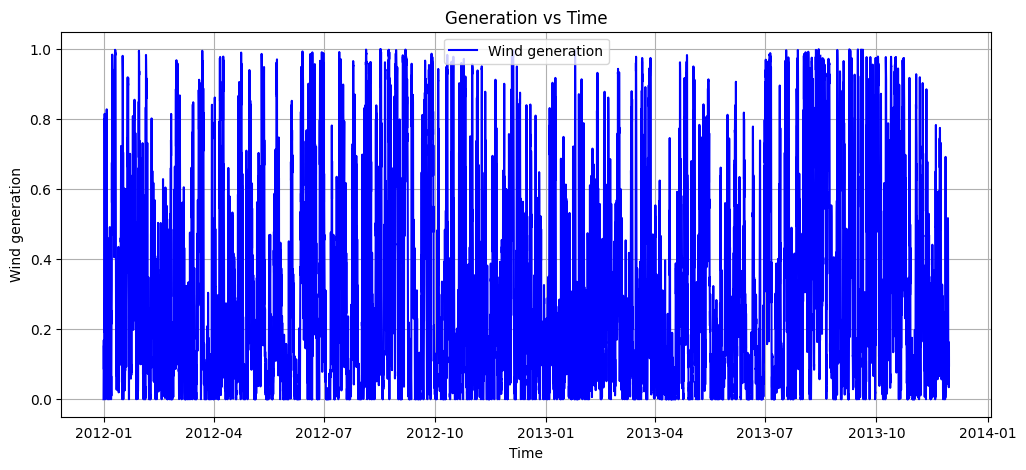

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is already loaded
# Parse TIMESTAMP correctly
df["DATETIME"] = pd.to_datetime(df["TIMESTAMP"], format="%Y%m%d %H:%M")

# Plot TARGETVAR vs time
plt.figure(figsize=(12,5))
plt.plot(df["DATETIME"], df["TARGETVAR"], label="Wind generation", color="blue")

plt.xlabel("Time")
plt.ylabel("Wind generation")
plt.title("Generation vs Time")
plt.legend()
plt.grid(True)
plt.show()


In [4]:
import pandas as pd

# Assuming df is your DataFrame
print(df.isnull().values.any())
print(df.isnull().sum())


True
TIMESTAMP     0
TARGETVAR    11
U10           0
V10           0
U100          0
V100          0
DATETIME      0
dtype: int64


In [5]:
# Assuming df is your DataFrame
print(df.shape)


(16776, 7)


In [6]:
df_clean = df.dropna()
print(df_clean.isnull().values.any())

False


In [7]:

print(df_clean.describe())

          TARGETVAR           U10           V10          U100          V100  \
count  16765.000000  16765.000000  16765.000000  16765.000000  16765.000000   
mean       0.303185      0.940752     -0.250430      1.578493     -0.553505   
min        0.000000     -7.494252     -9.993858    -10.910809    -15.294866   
25%        0.063340     -1.054875     -2.339638     -1.727161     -4.612543   
50%        0.206841      0.794029     -0.042559      1.498896      0.131772   
75%        0.479184      2.589976      1.928742      4.686743      3.489849   
max        1.000000     11.117029      9.508798     16.988418     14.314416   
std        0.289702      2.554971      2.920808      4.262562      5.029510   

                            DATETIME  
count                          16765  
mean   2012-12-15 09:08:39.439307776  
min              2012-01-01 01:00:00  
25%              2012-06-23 16:00:00  
50%              2012-12-15 07:00:00  
75%              2013-06-08 01:00:00  
max            

In [22]:
import pandas as pd
import numpy as np

TIME_COL   = "TIMESTAMP"
TARGET_COL = "TARGETVAR"
BASE_FEATS = ["U10", "V10", "U100", "V100"]

LAGS_Y     = [1, 3, 6, 12, 24]
LAGS_SPEED = [1, 3, 6]
ROLLS_Y    = [6, 12, 24]

def _ensure_datetime(col: pd.Series) -> pd.Series:
    """Try common parses: ISO strings, then UNIX seconds, then UNIX ms."""
    s = pd.to_datetime(col, errors="coerce", utc=True)
    if s.isna().any():
        # try unix seconds
        s2 = pd.to_datetime(col, unit="s", errors="coerce", utc=True)
        s = s.fillna(s2)
    if s.isna().any():
        # try unix milliseconds
        s3 = pd.to_datetime(col, unit="ms", errors="coerce", utc=True)
        s = s.fillna(s3)
    # If timezone-aware, convert to your local (Asia/Colombo) then make naive.
    try:
        s = s.tz_convert("Asia/Colombo").tz_localize(None)
    except Exception:
        # If it was naive already, just leave it
        pass
    return s

def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # --- make sure TIMESTAMP is datetime ---
    if TIME_COL not in out.columns:
        raise KeyError(f"Missing required column: {TIME_COL}")
    out[TIME_COL] = _ensure_datetime(out[TIME_COL])
    if out[TIME_COL].isna().any():
        bad = out.loc[out[TIME_COL].isna(), TIME_COL].head(5).tolist()
        raise ValueError(f"Could not parse some {TIME_COL} values. Examples: {bad}")

    # sort by time to make lags/rolls consistent
    out = out.sort_values(TIME_COL).reset_index(drop=True)

    # --- wind speed & direction ---
    out["speed10"]  = np.sqrt(out["U10"]**2  + out["V10"]**2)
    out["speed100"] = np.sqrt(out["U100"]**2 + out["V100"]**2)
    dir10  = np.arctan2(out["V10"],  out["U10"])
    dir100 = np.arctan2(out["V100"], out["U100"])
    out["dir10_sin"], out["dir10_cos"]   = np.sin(dir10),  np.cos(dir10)
    out["dir100_sin"], out["dir100_cos"] = np.sin(dir100), np.cos(dir100)

    # --- shear & veer ---
    out["shear_speed"] = out["speed100"] - out["speed10"]
    veer = dir100 - dir10
    out["veer_sin"], out["veer_cos"] = np.sin(veer), np.cos(veer)

    # --- time features (safe now that TIMESTAMP is datetime) ---
    out["hour"] = out[TIME_COL].dt.hour
    out["day"]  = out[TIME_COL].dt.dayofyear
    out["hour_sin"] = np.sin(2*np.pi*out["hour"]/24.0)
    out["hour_cos"] = np.cos(2*np.pi*out["hour"]/24.0)
    out["day_sin"]  = np.sin(2*np.pi*out["day"]/366.0)
    out["day_cos"]  = np.cos(2*np.pi*out["day"]/366.0)

    # --- target lags (shifted) ---
    if TARGET_COL not in out.columns:
        raise KeyError(f"Missing required column: {TARGET_COL}")
    for L in LAGS_Y:
        out[f"y_lag{L}"] = out[TARGET_COL].shift(L)

    # --- rolling means of y (shift 1 to avoid leakage) ---
    for W in ROLLS_Y:
        out[f"y_roll{W}"] = (
            out[TARGET_COL].shift(1).rolling(W, min_periods=W).mean()
        )

    # --- speed lags ---
    for L in LAGS_SPEED:
        out[f"speed10_lag{L}"]  = out["speed10"].shift(L)
        out[f"speed100_lag{L}"] = out["speed100"].shift(L)

    return out


In [31]:
x = add_engineered_features(df)
print(x.head())

                  TIMESTAMP  TARGETVAR       U10       V10      U100  \
0 2012-01-01 01:00:00+00:00   0.000000  2.124600 -2.681966  2.864280   
1 2012-01-01 02:00:00+00:00   0.054879  2.521695 -1.796960  3.344859   
2 2012-01-01 03:00:00+00:00   0.110234  2.672210 -0.822516  3.508448   
3 2012-01-01 04:00:00+00:00   0.165116  2.457504 -0.143642  3.215233   
4 2012-01-01 05:00:00+00:00   0.156940  2.245898  0.389576  2.957678   

       V100            DATETIME   speed10  speed100  dir10_sin  ...  y_lag24  \
0 -3.666076 2012-01-01 01:00:00  3.421530  4.652334  -0.783850  ...      NaN   
1 -2.464761 2012-01-01 02:00:00  3.096451  4.154892  -0.580329  ...      NaN   
2 -1.214093 2012-01-01 03:00:00  2.795932  3.712577  -0.294183  ...      NaN   
3 -0.355546 2012-01-01 04:00:00  2.461699  3.234831  -0.058351  ...      NaN   
4  0.332701 2012-01-01 05:00:00  2.279435  2.976332   0.170909  ...      NaN   

   y_roll6  y_roll12  y_roll24  speed10_lag1  speed100_lag1  speed10_lag3  \
0      Na

In [24]:
print(df.head())

       TIMESTAMP  TARGETVAR       U10       V10      U100      V100  \
0  20120101 1:00   0.000000  2.124600 -2.681966  2.864280 -3.666076   
1  20120101 2:00   0.054879  2.521695 -1.796960  3.344859 -2.464761   
2  20120101 3:00   0.110234  2.672210 -0.822516  3.508448 -1.214093   
3  20120101 4:00   0.165116  2.457504 -0.143642  3.215233 -0.355546   
4  20120101 5:00   0.156940  2.245898  0.389576  2.957678  0.332701   

             DATETIME  
0 2012-01-01 01:00:00  
1 2012-01-01 02:00:00  
2 2012-01-01 03:00:00  
3 2012-01-01 04:00:00  
4 2012-01-01 05:00:00  


In [29]:
# Convert all datetime columns to timezone-naive
for col in x.select_dtypes(include=["datetimetz"]).columns:
    x[col] = x[col].dt.tz_localize(None)

# Now save to Excel
x.to_excel("new_dataset.xlsx", index=False)


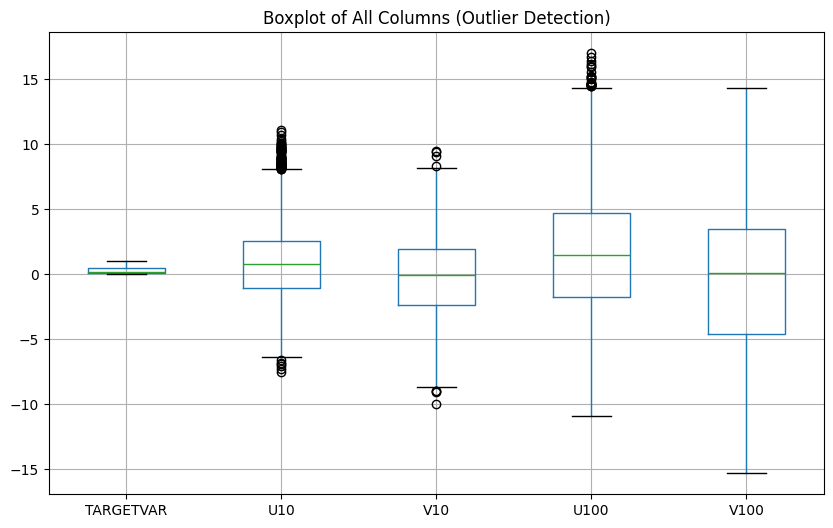

In [9]:
import matplotlib.pyplot as plt

df_clean.boxplot(figsize=(10,6))
plt.title("Boxplot of All Columns (Outlier Detection)")
plt.show()


In [10]:
# Assuming df is your original DataFrame
df_new1 = df_clean.drop(columns=["TIMESTAMP"])

# Check the new DataFrame
print(df_new1.head())


   TARGETVAR       U10       V10      U100      V100            DATETIME
0   0.000000  2.124600 -2.681966  2.864280 -3.666076 2012-01-01 01:00:00
1   0.054879  2.521695 -1.796960  3.344859 -2.464761 2012-01-01 02:00:00
2   0.110234  2.672210 -0.822516  3.508448 -1.214093 2012-01-01 03:00:00
3   0.165116  2.457504 -0.143642  3.215233 -0.355546 2012-01-01 04:00:00
4   0.156940  2.245898  0.389576  2.957678  0.332701 2012-01-01 05:00:00


In [11]:


# Suppose df is your edited DataFrame
df.to_excel("cleaned.xlsx", index=False)  


In [12]:
import pandas as pd

# Assuming df is your cleaned DataFrame (no nulls)
corr_matrix = df_new1.corr()
print(corr_matrix)


           TARGETVAR       U10       V10      U100      V100  DATETIME
TARGETVAR   1.000000  0.380003 -0.192178  0.367991 -0.201522  0.057833
U10         0.380003  1.000000 -0.087434  0.979927 -0.047560  0.089689
V10        -0.192178 -0.087434  1.000000 -0.127588  0.979846 -0.101615
U100        0.367991  0.979927 -0.127588  1.000000 -0.090110  0.096062
V100       -0.201522 -0.047560  0.979846 -0.090110  1.000000 -0.105132
DATETIME    0.057833  0.089689 -0.101615  0.096062 -0.105132  1.000000


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [14]:

# =========================
# 1. Load & preprocess data
# =========================
# Assume df is your dataframe with TARGETVAR + features
df_new = df_clean.drop(columns=["TIMESTAMP","DATETIME"])  # drop timestamp

data = df_new.values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


In [15]:
# =========================
# 2. Create sequences
# =========================
n_steps = 3  # lookback steps
X, y = [], []
for i in range(n_steps, len(scaled_data)):
    X.append(scaled_data[i-n_steps:i, 1:])  # features
    y.append(scaled_data[i, 0])             # target

X = np.array(X)
y = np.array(y)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1,1)

dataset = TensorDataset(X_tensor, y_tensor)

# Train-test split
train_size = int(0.8*len(dataset))
test_size = len(dataset)-train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [16]:
# =========================
# 3. Define LSTM (NO class)
# =========================
input_size = X_tensor.shape[2]
hidden_size = 50
num_layers = 1

lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
fc = nn.Linear(hidden_size, 1)



In [17]:
# =========================
# 4. Train loop
# =========================
criterion = nn.MSELoss()
params = list(lstm.parameters()) + list(fc.parameters())
optimizer = optim.Adam(params, lr=0.001)

num_epochs = 50

for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        out, _ = lstm(X_batch)
        out = out[:, -1, :]     # last step
        y_pred = fc(out)

        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

# =========================
# 5. Prediction
# =========================
lstm.eval()
fc.eval()
y_test_pred = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        out, _ = lstm(X_batch)
        out = out[:, -1, :]
        y_pred = fc(out)
        y_test_pred.append(y_pred)

y_test_pred = torch.cat(y_test_pred, dim=0).numpy()

# Inverse scaling
y_test_original = scaler.inverse_transform(
    np.hstack([y_tensor[train_size:].numpy(), np.zeros((len(y_tensor)-train_size, scaled_data.shape[1]-1))])
)[:,0]

y_pred_original = scaler.inverse_transform(
    np.hstack([y_test_pred, np.zeros((y_test_pred.shape[0], scaled_data.shape[1]-1))])
)[:,0]



KeyboardInterrupt: 

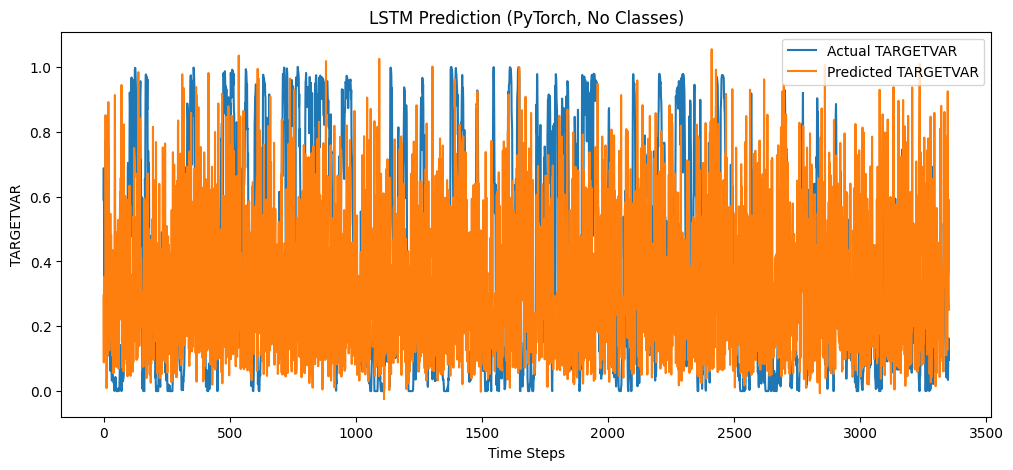

In [ ]:
# =========================
# 6. Plot results
# =========================
plt.figure(figsize=(12,5))
plt.plot(y_test_original, label="Actual TARGETVAR")
plt.plot(y_pred_original, label="Predicted TARGETVAR")
plt.xlabel("Time Steps")
plt.ylabel("TARGETVAR")
plt.title("LSTM Prediction (PyTorch, No Classes)")
plt.legend()
plt.show()


In [ ]:
torch.save({
    "lstm_state_dict": lstm.state_dict(),
    "fc_state_dict": fc.state_dict(),
    "scaler": scaler  # saves your MinMaxScaler too
}, "lstm_model.pth")


/home/sulith/LSTM/LSTM_Wind_assignment/LSTM/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


n_steps=12, hidden=50, layers=1, lr=0.001, Test Loss=0.630987
n_steps=12, hidden=50, layers=1, lr=0.0005, Test Loss=0.511305
n_steps=12, hidden=50, layers=2, lr=0.001, Test Loss=0.615672
n_steps=12, hidden=50, layers=2, lr=0.0005, Test Loss=0.571367
n_steps=12, hidden=100, layers=1, lr=0.001, Test Loss=0.693502
n_steps=12, hidden=100, layers=1, lr=0.0005, Test Loss=0.606856
n_steps=12, hidden=100, layers=2, lr=0.001, Test Loss=0.614759
n_steps=12, hidden=100, layers=2, lr=0.0005, Test Loss=0.663076
n_steps=24, hidden=50, layers=1, lr=0.001, Test Loss=0.572768
n_steps=24, hidden=50, layers=1, lr=0.0005, Test Loss=0.585558
n_steps=24, hidden=50, layers=2, lr=0.001, Test Loss=0.626654
n_steps=24, hidden=50, layers=2, lr=0.0005, Test Loss=0.654627
n_steps=24, hidden=100, layers=1, lr=0.001, Test Loss=0.594664
n_steps=24, hidden=100, layers=1, lr=0.0005, Test Loss=0.603044
n_steps=24, hidden=100, layers=2, lr=0.001, Test Loss=0.584540
n_steps=24, hidden=100, layers=2, lr=0.0005, Test Loss=0

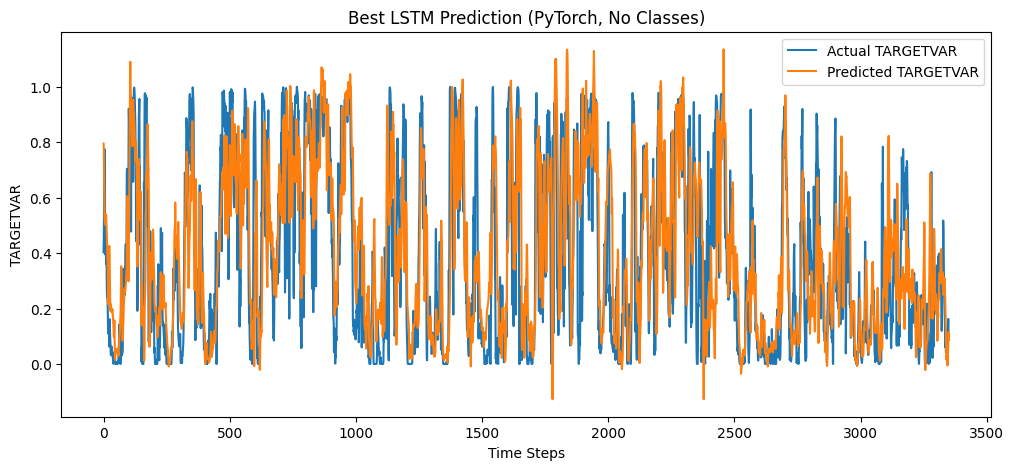

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# =========================
# 1. Load & preprocess data
# =========================
df_new = df_clean.drop(columns=["TIMESTAMP","DATETIME"])  # drop timestamp
data = df_new.values

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Function to create sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 1:])  # features
        y.append(data[i, 0])             # target
    return np.array(X), np.array(y)

# =========================
# 2. Hyperparameters to try
# =========================
n_steps_list = [12, 24]           # lookback window
hidden_sizes = [50, 100]          # LSTM hidden units
num_layers_list = [1, 2]          # number of LSTM layers
learning_rates = [0.001, 0.0005]  # learning rates
num_epochs = 100

best_loss = float("inf")
best_config = None
best_predictions = None

# =========================
# 3. Hyperparameter search
# =========================
for n_steps in n_steps_list:
    X, y = create_sequences(scaled_data, n_steps)
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1,1)

    # Chronological split
    train_size = int(0.8*len(X_tensor))
    X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
    y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    input_size = X_tensor.shape[2]

    for hidden_size in hidden_sizes:
        for num_layers in num_layers_list:
            for lr in learning_rates:
                # Define model (no class, just functions)
                lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
                fc = nn.Linear(hidden_size, 1)

                criterion = nn.MSELoss()
                params = list(lstm.parameters()) + list(fc.parameters())
                optimizer = optim.Adam(params, lr=lr)

                # Training
                for epoch in range(num_epochs):
                    for X_batch, y_batch in train_loader:
                        out, _ = lstm(X_batch)
                        out = out[:, -1, :]   # last timestep
                        y_pred = fc(out)
                        loss = criterion(y_pred, y_batch)

                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # Evaluate on test set
                lstm.eval(); fc.eval()
                test_loss = 0
                y_pred_all = []

                with torch.no_grad():
                    for X_batch, y_batch in test_loader:
                        out, _ = lstm(X_batch)
                        out = out[:, -1, :]
                        y_pred = fc(out)
                        test_loss += criterion(y_pred, y_batch).item()
                        y_pred_all.append(y_pred)

                test_loss /= len(test_loader)
                print(f"n_steps={n_steps}, hidden={hidden_size}, layers={num_layers}, lr={lr}, Test Loss={test_loss:.6f}")

                if test_loss < best_loss:
                    best_loss = test_loss
                    best_config = (n_steps, hidden_size, num_layers, lr)
                    best_predictions = torch.cat(y_pred_all, dim=0).numpy()

# =========================
# 4. Show best results
# =========================
print("\nBest Config:", best_config, "with Test Loss:", best_loss)

# Inverse scale target + predictions
n_steps = best_config[0]
_, y = create_sequences(scaled_data, n_steps)

y_test_original = scaler.inverse_transform(
    np.hstack([y_tensor[train_size:].numpy(), np.zeros((len(y_tensor)-train_size, scaled_data.shape[1]-1))])
)[:,0]

y_pred_original = scaler.inverse_transform(
    np.hstack([best_predictions, np.zeros((best_predictions.shape[0], scaled_data.shape[1]-1))])
)[:,0]

plt.figure(figsize=(12,5))
plt.plot(y_test_original, label="Actual TARGETVAR")
plt.plot(y_pred_original, label="Predicted TARGETVAR")
plt.xlabel("Time Steps")
plt.ylabel("TARGETVAR")
plt.title("Best LSTM Prediction (PyTorch, No Classes)")
plt.legend()
plt.show()


In [ ]:
import joblib

# Save model weights
torch.save({
    "lstm_state_dict": lstm.state_dict(),
    "fc_state_dict": fc.state_dict(),
    "best_config": best_config
}, "lstm_model3.pth")

# Save scaler
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']